## Digital Image Processing, ECE419

Ernesto Colon

The Cooper Union Department of Electrical Engineering


February 19th, 2021

References:
- Digital Image Processing Using Matlab [DIPUM] by Gonzalez et al., 3rd ed
- Digital Image Processing by Gonzalez et al., 4th ed

**The following set of notes and example scripts are part of my independent study sessions and adapted from the references outlined above. My main reference is DIPUM and complemented with online documentation. As I go through the theory and textbook examples, I am translating the code and image processing techniques to Python.**

## Color Image Processing Notes / Exercises

In [1]:
#Importing the libraries
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import ec_img_utils
import skimage.util
from skimage import io
import scipy.fft
from skimage import transform
import pandas as pd
import skimage.color
from PIL import Image, ImageCms

Objects may reflect, absorb or transmit light that strikes them. The amount of light that is reflected by an object,
for example, is typically a function of the light's wavelength. This wavelength dependency in addition to the properties
of the illuminating source and the way our visual system works gives rise to color perception.

The human eye has two type of light sensitive cells, *rods* and *cones*. The rods are active mainly in low light
situations, and their contribution to color perception is minimal. That is the reason why we see the world almost as
grayscale at night when there is not much illumination around us. The cone cells, on the other hand, activate at higher
light intensity levels and are responsible for sending color information to our brain.

An illuminating source has a specific power spectral density associated with it which we can denote as $P(\lambda)$.
When we have the illuminating source's PSD and the object's relative reflectance curves, we can compute how an object
responds to the illumination as a function of wavelength.

Colors can be represented as points in multi-dimensional space. The most familiar color space to us is the RGB space.
The RGB color space is only one of many color spaces in widespread use. We refer to the color space dimensions as the
*primaries*. For example, in the RGB color space, the red, green, and blue are the primaries.

In a color matching experiment, Wright and Guild and Petavel (independently) had a light source with a known PSD and
three monochromatic primaries that they varied in different intensity combinations until individuals perceived the
combinations as the known light source. The result is a set of color matching functions
($\bar r(\lambda),\bar b(\lambda), \bar b(\lambda)$) that can be used to compute tristimulus values. These are the
well-known RGB values we are used to working with. The RGB tristimulus values can be computed as follows:

\begin{equation}
R = \int_{380}^{780} \bar r(\lambda)P(\lambda) \,d\lambda
\end{equation}

\begin{equation}
G = \int_{380}^{780} \bar g(\lambda)P(\lambda) \,d\lambda
\end{equation}

\begin{equation}
B = \int_{380}^{780} \bar b(\lambda)P(\lambda) \,d\lambda
\end{equation}

The International Commission on Illumination (CIE) is a standardization body or commission as the name explicitly calls
out, that defines certain conventions. For example, one set of tristimulus values that are usef very widely are the XYZ
primaries. These are related to RGB via the linear transformation:

\begin{equation}
\begin{bmatrix} X \\ Y \\ Z \end{bmatrix}
= \begin{bmatrix}
2.768892 & 1.751748 & 1.130160\\
1.000000 & 4.590700 & 0.060100\\
0.000000 & 0.056508 & 5.594292
\end{bmatrix}
\begin{bmatrix} R \\ G \\ B \end{bmatrix}
\end{equation}

Below, we plot the set of matching functions corresponding to both the RGB and XYZ color spaces. The support package for
DIPUM 3rd ed. has the CIE Standard Observer xyz color matching functions as a function of wavelength in steps of 1nm. I
wrote a function to go from xyz to rgb and vice versa and obtained the corresponding rgb color matching functions as well.

As outlined in DIPUM, the RGB to XYZ transformation was chosen so that:

- The resulting color matching functions are nonnegative.
- When $P(\lambda)$ is a constant (equienergy stimulus), the tristimulus values are equal.
- One of the tristimulus valuess (Y) equals the luminance of the stimilus.

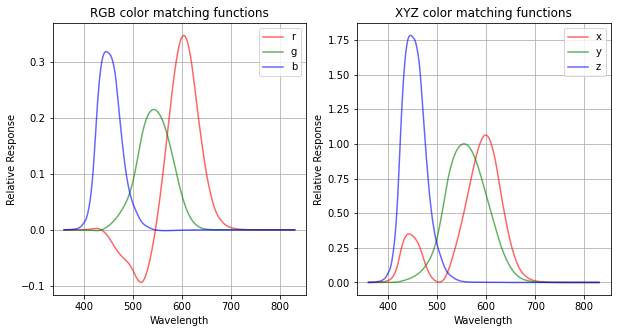

In [2]:
# import the CIE 1931 Standard Observer Data
cie_std_obs = pd.read_csv('CIE 1931 Standard Observer (1nm)_csv.csv')

# convert from XYZ to RGB using my custom function (see ec_img_utils)
cie_std_obs_rgb = ec_img_utils.my_xyz2rgb(cie_std_obs.to_numpy()[:, 1:4])

# plot the x, y, z color matching functions
fig_col_mat, ax_col_mat = plt.subplots(1, 2, figsize=(10,5))
ax_col_mat = ax_col_mat.ravel()

ax_col_mat[0].plot(cie_std_obs['lambda'], cie_std_obs_rgb[:,0], c='r', alpha=0.6, label='r')
ax_col_mat[0].plot(cie_std_obs['lambda'], cie_std_obs_rgb[:,1], c='g', alpha=0.6, label='g')
ax_col_mat[0].plot(cie_std_obs['lambda'], cie_std_obs_rgb[:,2], c='b', alpha=0.6, label='b')
ax_col_mat[0].set_title('RGB color matching functions')
ax_col_mat[0].set_xlabel('Wavelength')
ax_col_mat[0].set_ylabel('Relative Response');
ax_col_mat[0].legend()
ax_col_mat[0].grid()

ax_col_mat[1].plot(cie_std_obs['lambda'], cie_std_obs['x'], c='r', alpha=0.6, label='x')
ax_col_mat[1].plot(cie_std_obs['lambda'], cie_std_obs['y'], c='g', alpha=0.6, label='y')
ax_col_mat[1].plot(cie_std_obs['lambda'], cie_std_obs['z'], c='b', alpha=0.6, label='z')
ax_col_mat[1].set_title('XYZ color matching functions')
ax_col_mat[1].set_xlabel('Wavelength')
ax_col_mat[1].set_ylabel('Relative Response');
ax_col_mat[1].legend()
ax_col_mat[1].grid()


#### The Standard RGB Model

As outlined above, in the RGB color model, a color is described by three intensity values, R, G, and B corresponding to
red, green, and blue. The intensity values are in the range [0, 1]. When all primaries are at full strength, the color
is perceived as white. Similarly, when all primary intensities are zero, we have black.

We can visualize the RGB color space with an RGB color cube as shown below (plotted in Matlab using DIPUM function).
The vertices of the RGB color cube are the primary (rgb) colors and the secondary (cyan, magenta, and yellow) colors of
light.

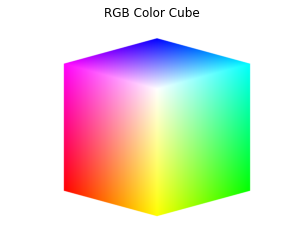

In [3]:
img_rgb_cube = io.imread('./images/rgb_color_cube.tif')
plt.figure()
plt.imshow(img_rgb_cube)
plt.title("RGB Color Cube")
plt.axis('off');

#### CMY and CMYK Color Models

The display on a computer uses an *additive process* for displaying colors in an sRGB space. In contrast, color printing
is a *subtractive process*. When illuminated with broad-spectrum (e.g., white) light, printed inks of different colors
absorb (or subtract) parts of the illumination spectrum. The remaining spectrum that is reflected back is the color
stimulus.

The most commonly used inks are cyan, magenta, and yellow and are often called *primary color pigments*.

A simplified CMY model can be expressed as follows:

\begin{equation}
\begin{bmatrix} C \\ M \\ Y \end{bmatrix}
= \begin{bmatrix} 1 \\ 1 \\ 1 \end{bmatrix} -
\begin{bmatrix} R \\ G \\ B \end{bmatrix}
\end{equation}

Where the RGB color values are normalized to the range [0, 1].

The CMYK model extends the CMY model by adding a fourth color, true black. The reason for this is because mixing CMY in
a subtractive process yields a muddy brown color instead of black. See DIP for more details about the definitions of the
CMYK space.

#### ICC Color Profiles

Different devices and/or media have different appearance, and thus, it is necessary to transform from one devices color
space/profile to another. The *International Color Consortium* (ICC) is an industry group that standardizes how to
create color profiles for display devices/media and transformations between them. The transformation between one color
profile to another is called *gamut mapping*. A *color gamut* is a volume in color space that defines the range of
colors that a device can reproduce. Color gamuts vary from device to device.

**Example 7.2 from DIPUM - Soft proofing using ICC profiles**

Soft proofing simulates on a computer monitor the appearance that a color image would have if printed.

First, we convert monitor colors (assuming sRGB) to output device colors using a perceptual rendering intent

Second, we convert computed output device colors back to monitor colors using the absolute colorimetric rendering intent

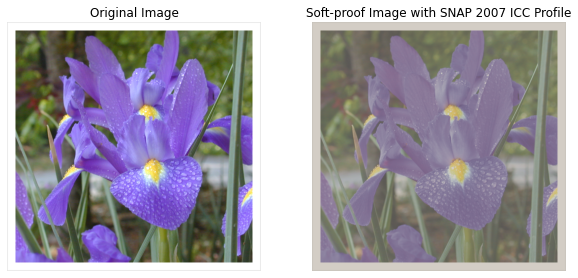

In [4]:
# load iris image
img_iris = io.imread('./images/iris-cropped-RGB.tif')

# pad image to create border
# white border
img_iris_pad = np.pad(img_iris, ((40, 40), (40, 40), (0, 0)), 'constant', constant_values=(255))

# gray border
img_iris_pad = np.pad(img_iris_pad, ((4, 4), (4, 4), (0, 0)), 'constant', constant_values=(230))

# convert image to PIL
img_iris_pil = Image.fromarray(img_iris_pad, 'RGB')

fig_iris, ax_iris = plt.subplots(1, 2, figsize=(10,5))
ax_iris = ax_iris.ravel()

ax_iris[0].imshow(img_iris_pad)
ax_iris[0].set_title("Original Image")

# get the ICC profile for my display
display_icc = ImageCms.get_display_profile()

# open ICC SNAP2007 profile downloaded from http://color.org/registry/index.xalter
snap07_icc = ImageCms.getOpenProfile('./files/SNAP2007.icc')

# create transform
col_xfm1 = ImageCms.buildTransform(display_icc, snap07_icc, inMode='RGB', outMode='CMYK')

# apply transform
img_iris_newsp = ImageCms.applyTransform(img_iris_pil, col_xfm1, inPlace=False)

# finally, create a second transform using the absolute colorimetric rendering intent to convert back to RGB
col_xfm2 = ImageCms.buildTransform(snap07_icc, display_icc, inMode='CMYK', outMode='RGB', renderingIntent=3)

# apply the transform and display the image
img_iris_sftprf = ImageCms.applyTransform(img_iris_newsp, col_xfm2, inPlace=False)

ax_iris[1].imshow(img_iris_sftprf)
ax_iris[1].set_title("Soft-proof Image with SNAP 2007 ICC Profile")

ax_iris[0].axis('off')
ax_iris[1].axis('off');

ADD COMMENTS

#### HSI and HSV

**Example 7.3 fdrom DIPUM - Converting from RGB to HSI**

In [5]:
# load fire breather image
img_firebrth = io.imread('./images/firebreather-midres.tif')

# convert to HSI color space
img_firebrth_hsi = ec_img_utils.my_rgb2hsi(img_firebrth)

# perform histogram equalization on the intensity channel of the HSI image
img_firebrth_int_histeq = skimage.exposure.equalize_hist(img_firebrth_hsi[:, :, 2])

# stack the transformed HSI image
img_firebrth_hsi_histeq = np.dstack((img_firebrth_hsi[:, :, 0], img_firebrth_hsi[:, :, 1], img_firebrth_int_histeq))

img_firebrth_hsi_histeq_rgb = ec_img_utils.my_hsi2rgb(img_firebrth_hsi_histeq)

(-0.5, 1643.5, 1207.5, -0.5)

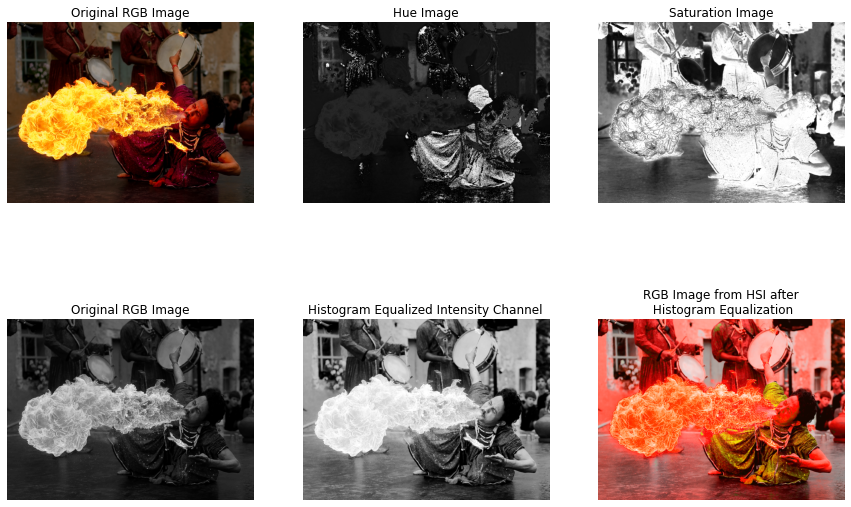

In [6]:
# display the images
fig_fire, ax_fire = plt.subplots(2, 3, figsize=(15,10))
ax_fire = ax_fire.ravel()

ax_fire[0].imshow(img_firebrth)
ax_fire[0].set_title("Original RGB Image")
ax_fire[0].axis('off')

ax_fire[1].imshow(img_firebrth_hsi[:, :, 0], cmap='gray')
ax_fire[1].set_title("Hue Image")
ax_fire[1].axis('off')

ax_fire[2].imshow(img_firebrth_hsi[:, :, 1], cmap='gray')
ax_fire[2].set_title("Saturation Image")
ax_fire[2].axis('off')

ax_fire[3].imshow(img_firebrth_hsi[:, :, 2], cmap='gray')
ax_fire[3].set_title("Original RGB Image")
ax_fire[3].axis('off')

ax_fire[4].imshow(img_firebrth_int_histeq, cmap='gray')
ax_fire[4].set_title("Histogram Equalized Intensity Channel")
ax_fire[4].axis('off')

ax_fire[5].imshow(img_firebrth_hsi_histeq_rgb)
ax_fire[5].set_title("RGB Image from HSI after\n Histogram Equalization")
ax_fire[5].axis('off')


ADD COMMENTS

#### Color Transformations

Next, let's explore color transformations within the confines of a single color space. We will treat transformations of
the form

\begin{equation}
s_i = T_i(r_i) \quad i = 1, 2, ..., n
\end{equation}

where $r_i$ and $s_i$ are the color components of the input and output images, $n$ is the dimension of (or number of
color components in) the color space of $r_i$, and $T_i$ are referred to as *full-color transformation* (or *mapping*)
*functions*.

If the input images are monochrome, then we write the transformation as:

\begin{equation}
s_i = T_i(r) \quad i = 1, 2, ..., n
\end{equation}

where $r$ denotes the graylevel values, $s_i$ and $T_i$ are as above, and $n$ is the number of color components in $s_i$.
This equation describes the mapping of gray levels into arbitrary colors, a process we refer to as *pesudocolor
transformation* or *pesudocolor mapping*.

One way to specify color transformations is through control points. We can then use interpolation techniques to specify
the full transformation. Let's take a look at two examples below.

**Specifying CONTROL POINTS for color transformations...**

Useful link explaining how to interpolate using query points in Python usinc scipy
https://docs.scipy.org/doc/scipy/reference/tutorial/interpolate.html#spline-interpolation-in-1-d-procedural-interpolate-splxxx

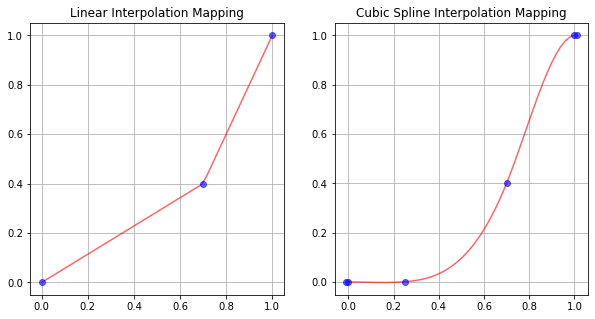

In [7]:
ctrl_pts_1 = np.array([[0.0, 0.0],
                       [0.7, 0.4],
                       [1.0, 1.0]])

# interpolate
eval_pts = np.linspace(0.0, 1.0)

# linear interpolation
lin_interp = np.interp(eval_pts, ctrl_pts_1[:, 0], ctrl_pts_1[:, 1])

# spline interpolation
# first, create the spline interpolation given the control points with no smoothing, s = 0
ctrl_pts_2 = np.array([[-0.01, 0.0],
                       [0.0, 0.0],
                       [0.25, 0.001],
                       [0.7, 0.4],
                       [1.0, 1.0],
                       [1.01, 1.0]])

spline_rep = scipy.interpolate.splrep(ctrl_pts_2[:, 0], ctrl_pts_2[:, 1], s=0)

# evaluate spline
spline_interp = scipy.interpolate.splev(eval_pts, spline_rep, der=0)

# display the interpolated values
fig_col_xfm, ax_col_xfm = plt.subplots(1, 2, figsize=(10, 5))
ax_col_xfm =  ax_col_xfm.ravel()

ax_col_xfm[0].plot(eval_pts, lin_interp, c='r', alpha=0.6, label='Mapping Fcn')
ax_col_xfm[0].plot(ctrl_pts_1[:, 0], ctrl_pts_1[:,1], 'bo', alpha=0.6, label='Control Pts')
ax_col_xfm[0].grid()
ax_col_xfm[0].set_title("Linear Interpolation Mapping")

ax_col_xfm[1].plot(eval_pts, spline_interp, c='r', alpha=0.6, label='Mapping Fcn')
ax_col_xfm[1].plot(ctrl_pts_2[:, 0], ctrl_pts_2[:,1], 'bo', alpha=0.6, label='Control Pts')
ax_col_xfm[1].grid()
ax_col_xfm[1].set_title("Cubic Spline Interpolation Mapping");

Let's now create some transformation functions and process some images...

**Photographic Negative Example**

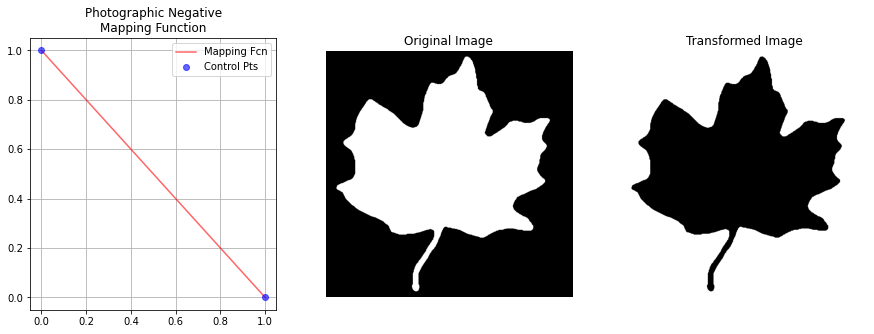

In [8]:
# load image
img_maple_leaf = io.imread('./images/mapleleaf.tif')

# specify the transformation function
maple_xfm_ctrl_pts = np.array([[0.0, 1.0],
                               [1.0, 0.0]])

# evaluate mapping function using linear interpolation
maple_interp_xfm = np.interp(eval_pts, maple_xfm_ctrl_pts[:, 0], maple_xfm_ctrl_pts[:, 1])

img_maple_neg = np.interp(img_maple_leaf, maple_xfm_ctrl_pts[:, 0], maple_xfm_ctrl_pts[:, 1])

# display images
fig_maple, ax_maple = plt.subplots(1, 3, figsize=(15, 5))
ax_maple = ax_maple.ravel()


ax_maple[0].plot(eval_pts, maple_interp_xfm, c='r', alpha=0.6, label='Mapping Fcn')
ax_maple[0].plot(maple_xfm_ctrl_pts[:, 0], maple_xfm_ctrl_pts[:, 1],'bo', alpha=0.6, label='Control Pts')
ax_maple[0].set_title("Photographic Negative\nMapping Function")
ax_maple[0].grid()
ax_maple[0].legend()

ax_maple[1].imshow(img_maple_leaf, cmap='gray')
ax_maple[1].set_title("Original Image")
ax_maple[1].axis('off')

ax_maple[2].imshow(img_maple_neg, cmap='gray')
ax_maple[2].set_title("Transformed Image")
ax_maple[2].axis('off');